Цель работы: разработать инструмент для обнаружения дефектов разрыва оксидного аморфного слоя, образовавшихся в результате приложения к образцам напряжения пробоя, а также их площади по электронно-микроскопическим изображениям с разным увеличением.

Задачи:
- определение оптимального размера изображения (в пикселях) для обучения модели и предсказания
    - использование полученной программы предпологает съемку крупного по площади изображения с определенным увеличением, нарезку его на части, получние предсказаний по каждой из них (попиксельно) и сборку предсказаний в изображение такого же размера как и исходное
- разметка изображений (попиксельная классификация) и их аугментация
    - какую долю от изображения должен занимать обнаруживаемый объект?
- обучение моделей разной глубины, предлагается взять за основу сверточные модели глубиной 6 (2700 параметров) и 9 (3700000 параметров) слоев из проектов по распознаванию жестов и пчел, соответственно. Необходимо выбрать оптимальную модель по соотношению скорость работы - точность, т.к. планируется обрабатывать изображения большой площади
- провести интерпретацию работы моделей (оценить результаты сверточных слоев по ядрам сверток, проверить выход после каждого слоя) для того чтобы определить какие участки дефектов являются наиболее важными для определения

Окно размером 100х100 пикселей на первый взгляд выглядит оптимальным, а также размер изображения 150 мкм HFW.

Изображения с увеличением 30 мкм HFW можно сжать в 4 раза.

Импортируем необходимые модули.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as sk
from pathlib import Path
from skimage import io

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Введем константы.

In [2]:
SEED = 515

Создадим два датафрейма с названиями файлов признаков и целевого признака для тренировочного и тестового наборов данных. 

- t0 - отметка о том, что на изображении не содержится дефектов и целевым признаком является нулевая матрица
- разрешение файлов features - **.jpg**, а файлов target - **.png**

In [3]:
labels = pd.read_csv('labels.csv', sep=';')
labels_research = pd.read_csv('labels_research.csv', sep=';')
print('labels of images:')
display(labels.head())

labels of images:


,features,target
0,f1_780A_ETD_1_004_1,t1_780A_ETD_1_004_1
1,f1_780A_ETD_3_008_1,t1_780A_ETD_3_008_1
2,f1_977A_ETD_1_002_1,t1_977A_ETD_1_002_1
3,f1_977A_ETD_1_002_2,t1_977A_ETD_1_002_2
4,f1_977A_ETD_2_006_1,t1_977A_ETD_2_006_1


Приведем для примера пару изображений (признак - разметка) из тренировочного набора.

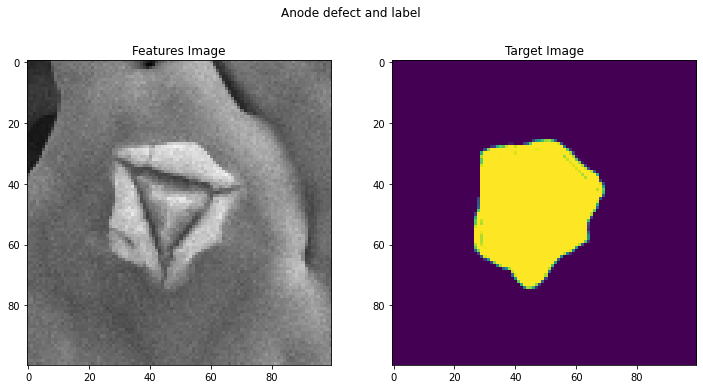

Features size: (100, 100, 3)
Target size: (100, 100)


In [4]:
example_features = plt.imread('images/{}.jpg'.format(labels.loc[0, 'features']))
example_target = plt.imread('images/{}.png'.format(labels.loc[0, 'target']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].imshow(example_features)
ax[1].imshow(example_target)
ax[0].set_title("Features Image")
ax[1].set_title("Target Image")
fig.suptitle("Anode defect and label")
plt.show()

image_high = example_features.shape[0]
image_width = example_features.shape[1]

print('Features size:', example_features.shape)
print('Target size:', example_target.shape)

Создадим функцию для перевода изображений в массив.

In [5]:
def images_to_arrays(labels_df, images_path):
    '''Функция принимает на вход датафрейм с названиями признаков и целевого признака,
       путь до файлов изображений.
       Открывает изображения и конвертирует их в два массива: признаков и меток.
       Выдает картеж из массива признаков и массива целевого признака.
       Разрешение файлов features - .jpg, а файлов target - .png.
       Если целевой признак равен t0, 
       то ему присваивается нулевой массив размеров с изображение признаков'''

    features_list = []
    target_list = []

    for index, col in labels_df.iterrows():
        
        features = plt.imread(images_path + '{}.jpg'.format(col['features']))
        features = sk.color.rgb2gray(features)
        features_list.append(features)

        if col['target'] == 't0':
            target_list.append(np.zeros((image_high, image_width)))

        elif col['target'] != 't0':
            target = plt.imread(images_path + '{}.png'.format(col['target']))
            target_list.append(target)

    X = np.array(features_list)
    y = np.round(np.array(target_list)).astype('int')
    
    return X, y

Создадим матрицы признаков и целевого признака.

In [6]:
X = images_to_arrays(labels, 'images/')[0]
y = images_to_arrays(labels, 'images/')[1]

print('X size:', X.shape)
print('X dtype:', X.dtype)
print('y size:', y.shape)
print('y dtype:', y.dtype)

X size: (20, 100, 100)
X dtype: float64
y size: (20, 100, 100)
y dtype: int32


Проверим соответствие массивов X и y.

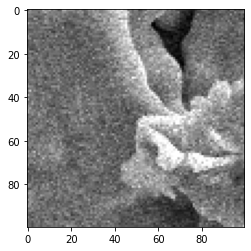

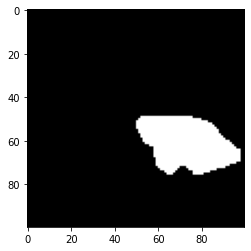

In [7]:
plt.imshow(X[5, :, :], cmap='gray')
plt.show()
plt.imshow(y[5, :, :], cmap='gray')
plt.show()

Изменим форму X и y.

In [8]:
X_reshape = X.reshape(-1, image_high, image_width, 1)
y_reshape = y.reshape(-1, image_high * image_width,)

Разделим массив данных на тренировачную и тестовую выборки.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_reshape, y_reshape, test_size=0.2, random_state=SEED)

print('X_train shape:', X_train.shape[1:])
print('y_train shape:', y_train.shape[1:])
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])

X_train shape: (100, 100, 1)
y_train shape: (10000,)
train samples: 16
test samples: 4


Создадим модель.

In [10]:
num_classes = image_high * image_width

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_high, image_width, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='sigmoid', name='preds'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 46, 46, 64)        0         
                                                                 
 flatten (Flatten)           (None, 135424)            0         
                                                        

Тренировка модели.

In [11]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=5,
          verbose=1,
          validation_split=0.25)
# batch_size=

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 764ms/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 890ms/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 735ms/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 708ms/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.0000e+00


Получение предсказания.

In [12]:
y_proba = model.predict(X_test[0:1,...])
y_pred = np.round(y_proba).astype('int')

1/1 [==============================] - 0s 216ms/step


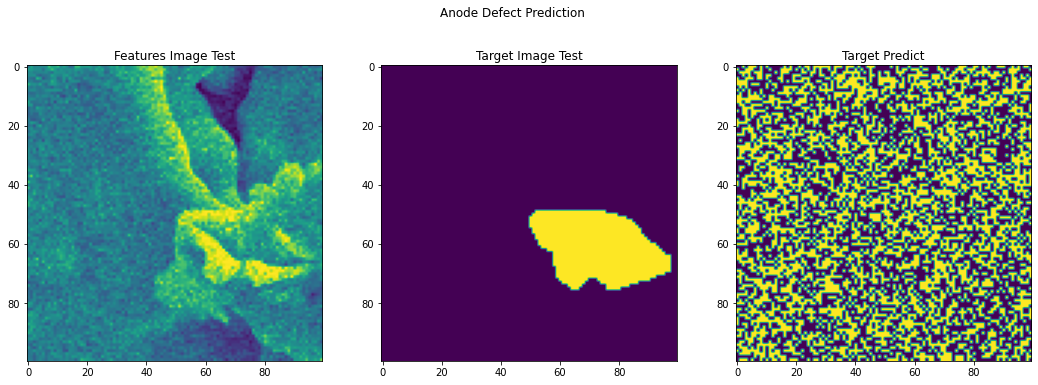

Defect Area on Target Image: 917
Defect Area on Prediction: 4972


In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

ax[0].imshow(X_test[0])
ax[1].imshow(y_test.reshape(-1, image_high, image_width,)[0])
ax[2].imshow(y_pred.reshape(-1, image_high, image_width,)[0])

ax[0].set_title("Features Image Test")
ax[1].set_title("Target Image Test")
ax[2].set_title("Target Predict")

fig.suptitle("Anode Defect Prediction")
plt.show()

print('Defect Area on Target Image:', y_test.reshape(-1, image_high, image_width,)[0].sum())
print('Defect Area on Prediction:', y_pred.reshape(-1, image_high, image_width,)[0].sum())